# Flight Delay Analysis

The goal of this project is to analyize flight delays and create a system to rank airlines. Data was provided by Kaggel.

In [35]:
import pandas as pd
import numpy as np
import glob
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()
current_palette = sns.color_palette()
sns.palplot(current_palette)
%matplotlib inline

In [13]:
# read all three data files
airlines = pd.read_csv('data/airlines.csv')
airports = pd.read_csv('data/airports.csv')
flights = pd.read_csv('data/flights.csv')

C:\Users\Masood\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (7,8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [3]:
airlines.head()

,IATA_CODE,AIRLINE
0,UA,United Air Lines Inc.
1,AA,American Airlines Inc.
2,US,US Airways Inc.
3,F9,Frontier Airlines Inc.
4,B6,JetBlue Airways


In [4]:
airlines.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 2 columns):
IATA_CODE    14 non-null object
AIRLINE      14 non-null object
dtypes: object(2)
memory usage: 304.0+ bytes


The `airlines` file contains the airline name as well as thier IATA Code. That's it.

In [5]:
airports.head()

,IATA_CODE,AIRPORT,CITY,STATE,COUNTRY,LATITUDE,LONGITUDE
0,ABE,Lehigh Valley International Airport,Allentown,PA,USA,40.65236,-75.44040
1,ABI,Abilene Regional Airport,Abilene,TX,USA,32.41132,-99.68190
2,ABQ,Albuquerque International Sunport,Albuquerque,NM,USA,35.04022,-106.60919
3,ABR,Aberdeen Regional Airport,Aberdeen,SD,USA,45.44906,-98.42183
4,ABY,Southwest Georgia Regional Airport,Albany,GA,USA,31.53552,-84.19447


In [6]:
airports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 322 entries, 0 to 321
Data columns (total 7 columns):
IATA_CODE    322 non-null object
AIRPORT      322 non-null object
CITY         322 non-null object
STATE        322 non-null object
COUNTRY      322 non-null object
LATITUDE     319 non-null float64
LONGITUDE    319 non-null float64
dtypes: float64(2), object(5)
memory usage: 17.7+ KB


The `airports` file contains the location of 322 airports. There over 40,000 airports in the world (including private and smaller ones). This only contains the major airports.

In [20]:
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,ARRIVAL_TIME,ARRIVAL_DELAY,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,408.0,-22.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,741.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,811.0,5.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,756.0,-9.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,259.0,-21.0,0,0,NaN,NaN,NaN,NaN,NaN,NaN


In [14]:
flights.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5819079 entries, 0 to 5819078
Data columns (total 31 columns):
YEAR                   int64
MONTH                  int64
DAY                    int64
DAY_OF_WEEK            int64
AIRLINE                object
FLIGHT_NUMBER          int64
TAIL_NUMBER            object
ORIGIN_AIRPORT         object
DESTINATION_AIRPORT    object
SCHEDULED_DEPARTURE    int64
DEPARTURE_TIME         float64
DEPARTURE_DELAY        float64
TAXI_OUT               float64
WHEELS_OFF             float64
SCHEDULED_TIME         float64
ELAPSED_TIME           float64
AIR_TIME               float64
DISTANCE               int64
WHEELS_ON              float64
TAXI_IN                float64
SCHEDULED_ARRIVAL      int64
ARRIVAL_TIME           float64
ARRIVAL_DELAY          float64
DIVERTED               int64
CANCELLED              int64
CANCELLATION_REASON    object
AIR_SYSTEM_DELAY       float64
SECURITY_DELAY         float64
AIRLINE_DELAY          float64
LATE_AIRCRAFT

The `flights` file contains every information we would need for analysis.

Info on a few import features:
- `AIR_TIME` - time duration between wheels_off and wheels_on time.
- `WHEELS_OFF` time point that the aircraft's wheels leave the ground.
- `WHEELS_ON` time point that the aircraft's wheels touch on the ground.
- `TAXI_OUT` time duration elapsed between departure from the origin airport gate and wheels off.
- `TAXI_IN` time duration elapsed between wheels-on and gate arrival at the destination airport.

- `departure_time` = `wheels_off` - `taxi_out`
- `departure_delay` = `departure_time` - `scheduled_departure`
- `arrival_time` = `wheels_on` + `taxi_in`
- `arrival_delay` = `arrival_time` - `scheduled_arrival`
- `elapsed_time` = `air_time` + `taxi_in` + `taxi_out`
- `air_time` = `wheels_on` - `wheels_off`


The time is formatted in hour:mintues (xx:yy). Example: 1458 indicates 1:58pm (or 14:58). Features which follow this formate are:
`scheduled_departure`, `departure_time`, `scheduled_arrival`, `arrival_time`, `wheels_off`, `wheels_on`

The following are only in minutes:
`arrival_delay`, `departure_delay`, `taxi_in`, `taxi_out`, `scheduled_time`, `elapsed_time`, `air_time`

In [15]:
# check for missing values 
flights.isna().sum()

YEAR                         0
MONTH                        0
DAY                          0
DAY_OF_WEEK                  0
AIRLINE                      0
FLIGHT_NUMBER                0
TAIL_NUMBER              14721
ORIGIN_AIRPORT               0
DESTINATION_AIRPORT          0
SCHEDULED_DEPARTURE          0
DEPARTURE_TIME           86153
DEPARTURE_DELAY          86153
TAXI_OUT                 89047
WHEELS_OFF               89047
SCHEDULED_TIME               6
ELAPSED_TIME            105071
AIR_TIME                105071
DISTANCE                     0
WHEELS_ON                92513
TAXI_IN                  92513
SCHEDULED_ARRIVAL            0
ARRIVAL_TIME             92513
ARRIVAL_DELAY           105071
DIVERTED                     0
CANCELLED                    0
CANCELLATION_REASON    5729195
AIR_SYSTEM_DELAY       4755640
SECURITY_DELAY         4755640
AIRLINE_DELAY          4755640
LATE_AIRCRAFT_DELAY    4755640
WEATHER_DELAY          4755640
dtype: int64

`DAY_OF_WEEK` is represented as a numeric value. I will convert this to the day names. The data file did not specify what number corresponds to which day, so using the first row YEAR = 1, MONTH = 1, DAY = 1. DAY_OF_WEEK =4 (ie. Jan 1, 2015), I concluded that 1 corresponds to Monday and 2 corresponds to Tuesday, etc.

In [24]:
flights['DAY_OF_WEEK'].unique()
day_of_week_desc={
    1:'Monday',
    2:'Tuesday',
    3:'Wednesday',
    4:'Thursday',
    5:'Friday',
    6:'Saturday',
    7:'Sunday'}

flights['DESC_DOW'] = flights['DAY_OF_WEEK'].apply(lambda x:day_of_week_desc[x])
flights.head()['DESC_DOW']

0    Thursday
1    Thursday
2    Thursday
3    Thursday
4    Thursday
Name: DESC_DOW, dtype: object

In [25]:
airlines_dict = dict(zip(airlines['IATA_CODE'],airlines['AIRLINE']))
airport_dict = dict(zip(airports['IATA_CODE'],airports['AIRPORT']))
flights['DESC_AIRLINE'] = flights['AIRLINE'].apply(lambda x: airlines_dict[x])
flights.head()['DESC_AIRLINE']

0      Alaska Airlines Inc.
1    American Airlines Inc.
2           US Airways Inc.
3    American Airlines Inc.
4      Alaska Airlines Inc.
Name: DESC_AIRLINE, dtype: object

A quick google search determined that a following factors are attributed to what makes a great airline. 
- Ratio of operated flights by scheduled flights
- Flight speed
- Average arrival delay
- Flight volume
- Taxi In and Out Time

In [26]:
#flights.CANCELLED.unique() #0,1
# a airline flight is either cancelled or not (meaning the flight is opertating)
airlines_top = pd.DataFrame(flights.groupby('DESC_AIRLINE').count()['SCHEDULED_DEPARTURE'])
airlines_top['CANCELLED'] = flights.groupby('DESC_AIRLINE').sum()['CANCELLED']
airlines_top['OPERATED'] = airlines_top['SCHEDULED_DEPARTURE'] - airlines_top['CANCELLED']
airlines_top['RATIO_OP_SCH'] = airlines_top['OPERATED']/airlines_top['SCHEDULED_DEPARTURE']
airlines_top.drop(airlines_top.columns[[0,1,2]], axis=1, inplace=True)
airlines_top.head()

,RATIO_OP_SCH
DESC_AIRLINE,
Alaska Airlines Inc.,0.996122
American Airlines Inc.,0.984960
American Eagle Airlines Inc.,0.949004
Atlantic Southeast Airlines,0.973371
Delta Air Lines Inc.,0.995634


Text(0.5, 1.0, 'Ratio of operated and scheduled flights')

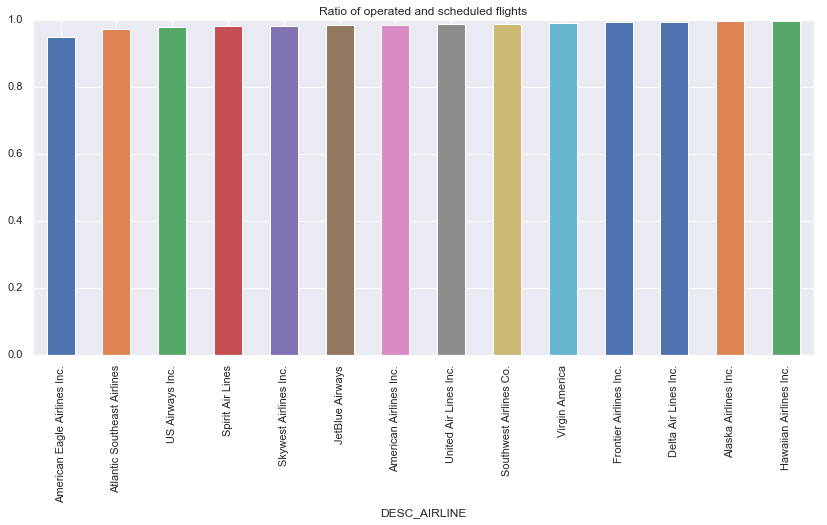

In [36]:
airlines_top.sort_values(['RATIO_OP_SCH'], ascending = 1, inplace=True)
# airlines_top.head()
airlines_top['RATIO_OP_SCH'].plot(kind='bar', figsize=(14,6), rot=90)
plt.title('Ratio of operated and scheduled flights')

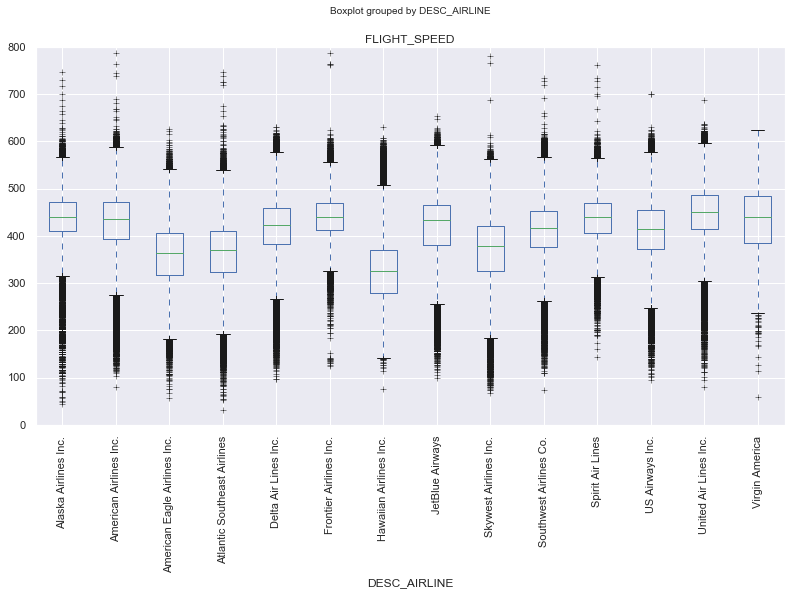

In [37]:
flights['FLIGHT_SPEED'] = 60*flights['DISTANCE']/flights['AIR_TIME']
airlines_top['FLIGHT_SPEED'] = flights.groupby('DESC_AIRLINE')['FLIGHT_SPEED'].mean()
flights[['DESC_AIRLINE','FLIGHT_SPEED']].boxplot(column = 'FLIGHT_SPEED',by='DESC_AIRLINE',figsize=(13,7),rot=90)

In [38]:
airlines_top.head()

,RATIO_OP_SCH,FLIGHT_SPEED
DESC_AIRLINE,,
American Eagle Airlines Inc.,0.949004,360.899443
Atlantic Southeast Airlines,0.973371,364.683738
US Airways Inc.,0.979534,411.108496
Spirit Air Lines,0.982927,436.499865
Skywest Airlines Inc.,0.983071,368.598815


In [39]:
airlines_top['FLIGHT_SPEED'].mean()

409.02464587790536

The average speed of flights is 409 miles per hour.

In [40]:
flights.groupby('DESC_AIRLINE')[['ARRIVAL_DELAY','DEPARTURE_DELAY']].mean()

# arrival delay 
airlines_top['ARRIVAL_DELAY']= flights.groupby('DESC_AIRLINE')['ARRIVAL_DELAY'].mean()

# convert ARRIVAL_DELAY to hours
airlines_top['ARRIVAL_DELAY']=airlines_top['ARRIVAL_DELAY'].apply(lambda x:x/60)

airlines_top.head()

,RATIO_OP_SCH,FLIGHT_SPEED,ARRIVAL_DELAY
DESC_AIRLINE,,,
American Eagle Airlines Inc.,0.949004,360.899443,0.107631
Atlantic Southeast Airlines,0.973371,364.683738,0.109756
US Airways Inc.,0.979534,411.108496,0.061770
Spirit Air Lines,0.982927,436.499865,0.241197
Skywest Airlines Inc.,0.983071,368.598815,0.097428


Analysis of `ARRIVAL_DELAY` and `DEPARTURE_DELAY`

[Text(0.5, 0, 'Mean flight delays (Arrival:Blue, Departure:Red)')]

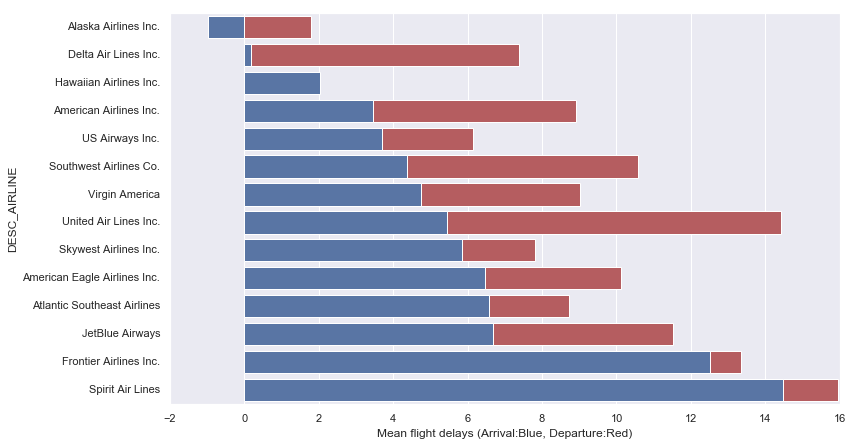

In [43]:
df_delay = pd.DataFrame(flights.groupby('DESC_AIRLINE')[['ARRIVAL_DELAY','DEPARTURE_DELAY']].mean())
df_delay.sort_values(['ARRIVAL_DELAY','DEPARTURE_DELAY'],ascending = [1,1],inplace=True)
plt.figure(figsize=(12,7))
sns.set_context(font_scale=2.5)
plot = sns.barplot(x='DEPARTURE_DELAY',y=df_delay.index, data=df_delay,color = 'r')
plot = sns.barplot(x='ARRIVAL_DELAY',y=df_delay.index, data=df_delay,color = 'b')
plot.set(xlabel='Mean flight delays (Arrival:Blue, Departure:Red)')

Off the bat, we see that Alaska Airlines has a negative arrival delay. Meaning that their flights arrive before its scheduled arrival time.

With the expection of United and American Airlines, all airlines have greater arrival delays than departure delays. Makes sense as a plane cannot depart if it has arrived late. Meaning depature delays are due to late arrivals.

Let's examine flight volume of each airline.

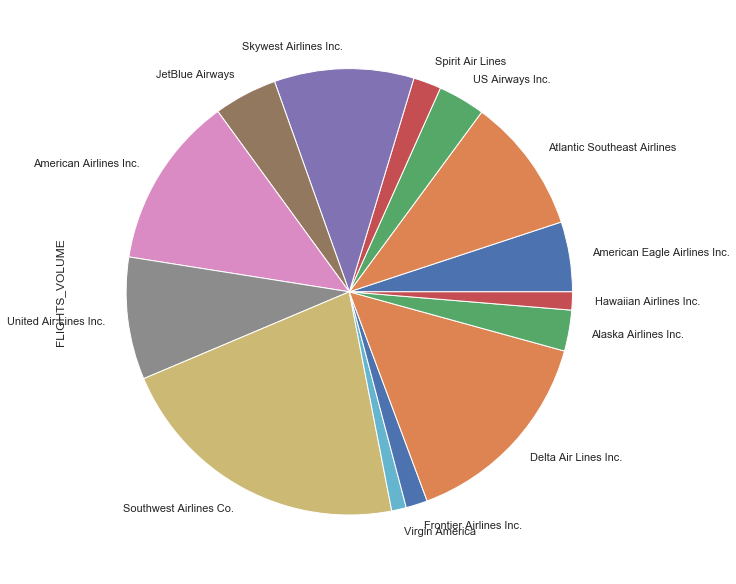

In [44]:
airlines_top['FLIGHTS_VOLUME'] = flights.groupby('DESC_AIRLINE')['FLIGHT_NUMBER'].count()
# ratio of flight_vol/total flight_vol
total = airlines_top['FLIGHTS_VOLUME'].sum()
airlines_top['FLIGHTS_VOLUME'] = airlines_top['FLIGHTS_VOLUME'].apply(lambda x:(x/float(total)))
airlines_top['FLIGHTS_VOLUME'].plot.pie(figsize=(10,10),rot=45)

Analysis of Taxi time.
- `TAXI_OUT`: time duration between departure from the origin airport gate and wheels off
- `TAXI_IN`: time duration between wheels-on and gate arrival at the destination airport

[Text(0.5, 0, 'Taxi Out and In Mean Times (Taxi Out: Red, Taxi In: Blue)')]

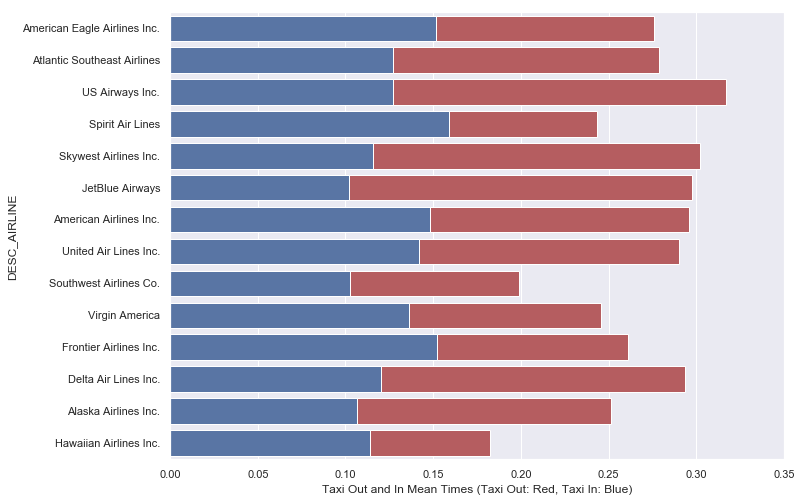

In [47]:
airlines_top[['TAXI_IN','TAXI_OUT']] = flights.groupby('DESC_AIRLINE')[['TAXI_IN','TAXI_OUT']].mean()

# convert time to hours
airlines_top['TAXI_IN'] = airlines_top['TAXI_IN'].apply(lambda x:(x/float(60)))
airlines_top['TAXI_OUT'] = airlines_top['TAXI_OUT'].apply(lambda x:(x/float(60)))

plt.figure(figsize=(11, 8))
sns.set_context(font_scale=2.5)
plot = sns.barplot(x='TAXI_OUT',y=airlines_top.index,data = airlines_top,color = 'r')
plot = sns.barplot(x='TAXI_IN',y=airlines_top.index,data = airlines_top,color = 'b')
plot.set(xlabel='Taxi Out and In Mean Times (Taxi Out: Red, Taxi In: Blue)')

Using the data we have generated, we can now rank the airlines. The formula I will use was given to me by instructor (score = a/(1+b)
a = speed, volume, raio of operated flights
b = arrival delay, taxi in, taxi out

In [48]:
# needed help with this
# normalize the data (valued from 1-2)
for i in airlines_top.columns:
    airlines_top[i] = ((airlines_top[i]-airlines_top[i].min())/(airlines_top[i].max()-airlines_top[i].min()))+1

a = airlines_top.RATIO_OP_SCH * airlines_top.FLIGHT_SPEED * airlines_top.FLIGHTS_VOLUME
b = airlines_top.ARRIVAL_DELAY * airlines_top.TAXI_IN * airlines_top.TAXI_OUT

airlines_top['SCORE'] = a/(1+b)
airlines_top.sort_values(['SCORE'],ascending=False,inplace=True)

airlines_top.head()

,RATIO_OP_SCH,FLIGHT_SPEED,ARRIVAL_DELAY,FLIGHTS_VOLUME,TAXI_IN,TAXI_OUT,SCORE
DESC_AIRLINE,,,,,,,
Southwest Airlines Co.,1.785210,1.693648,1.346414,2.000000,1.013475,1.122947,2.387937
Delta Air Lines Inc.,1.956436,1.734768,1.075304,1.678342,1.316631,1.826310,1.588619
Alaska Airlines Inc.,1.966448,1.890855,1.000000,1.092185,1.081595,1.514122,1.539632
American Airlines Inc.,1.737491,1.814826,1.286628,1.553423,1.801936,1.846313,0.927619
United Air Lines Inc.,1.784566,2.000000,1.414811,1.378198,1.694786,1.802211,0.924385


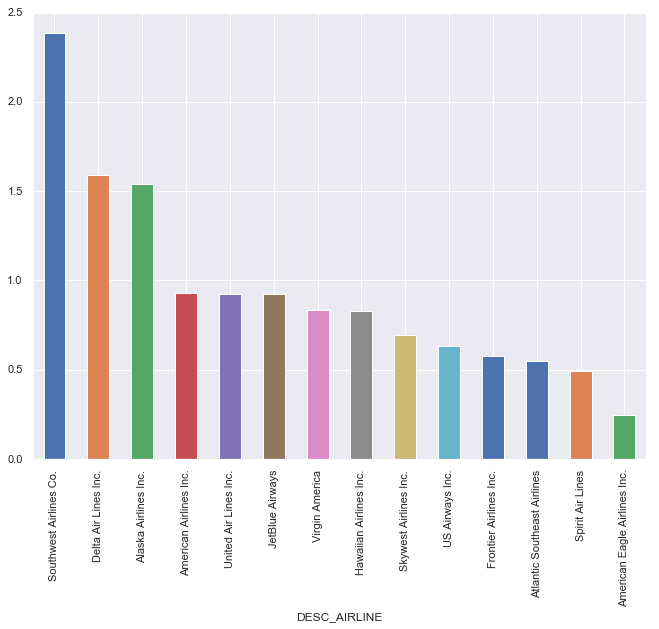

In [49]:
airlines_top['SCORE'].plot.bar(figsize = (11,8), rot=90)

Based on our ranking system, Southwest Airlines is the favorite.

## Other insights from the data

In [50]:
# which day in most busy
df_day = pd.DataFrame(flights.groupby('DESC_DOW').count()['SCHEDULED_DEPARTURE'])
df_day = df_day.sort_values(['SCHEDULED_DEPARTURE'])
df_day.head()

,SCHEDULED_DEPARTURE
DESC_DOW,
Saturday,700545
Sunday,817764
Tuesday,844600
Wednesday,855897
Friday,862209


Text(0.5, 1.0, 'Number of Scheduled flights per day')

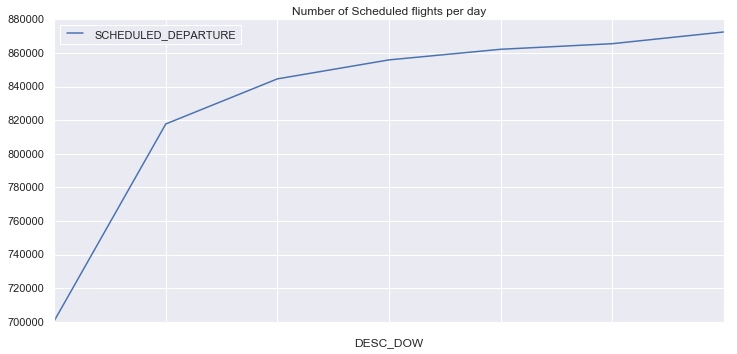

In [54]:
# for some reason the days of week are not showing up...
#day = ['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su']
df_day.plot(kind='line', subplots=True, figsize=(12,6), legend=True)
plt.title('Number of Scheduled flights per day')

Flight volume for each airline per day.

In [55]:
flight_volume = flights.pivot_table(index="DESC_DOW",columns="DESC_AIRLINE",values="SCHEDULED_DEPARTURE",aggfunc=lambda x:x.count())
flight_volume.head()

DESC_AIRLINE,Alaska Airlines Inc.,American Airlines Inc.,American Eagle Airlines Inc.,Atlantic Southeast Airlines,Delta Air Lines Inc.,Frontier Airlines Inc.,Hawaiian Airlines Inc.,JetBlue Airways,Skywest Airlines Inc.,Southwest Airlines Co.,Spirit Air Lines,US Airways Inc.,United Air Lines Inc.,Virgin America
DESC_DOW,,,,,,,,,,,,,,
Friday,25135,106374,43869,86299,130234,13242,11662,38801,86611,185731,16991,30246,77634,9380
Monday,25082,106225,43872,86979,131682,13228,10841,38902,87484,187228,16794,29391,78549,9286
Saturday,23574,92264,34246,63484,99365,11878,10559,35631,71767,151771,16844,24389,57675,7098
Sunday,24693,103049,41911,79547,124181,13058,10867,38742,84324,173081,16844,27724,71076,8667
Thursday,25477,108168,44314,87126,132064,13424,11031,39470,87902,187794,17054,30160,79126,9411


(array([ 0.5,  1.5,  2.5,  3.5,  4.5,  5.5,  6.5,  7.5,  8.5,  9.5, 10.5,
        11.5, 12.5, 13.5]), <a list of 14 Text xticklabel objects>)

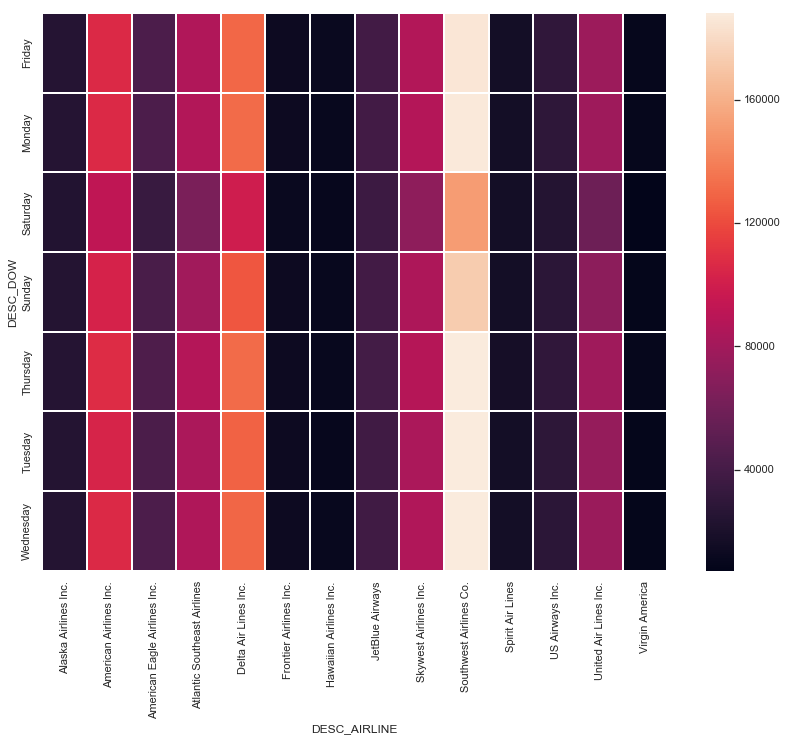

In [57]:
fig = plt.figure(figsize=(14,10))
sns.heatmap(flight_volume, linewidths=1)
plt.xticks(rotation=90)

## Flight cancellations and the reason

`CANCELLATION_REASON` have letters for values and each letter corresponds to a reason for canellation.

- A - Carrier
- B - Weather
- C - National Air System
- D - Security

In [58]:
df_cancel = pd.DataFrame(flights.groupby('DESC_DOW').sum()['CANCELLED'])
df_cancel=df_cancel.sort_values(['CANCELLED'])
df_cancel.head()

,CANCELLED
DESC_DOW,
Saturday,8749
Friday,8805
Wednesday,10729
Thursday,12291
Sunday,13165


Text(0.5, 1.0, 'Number of cancellations each day')

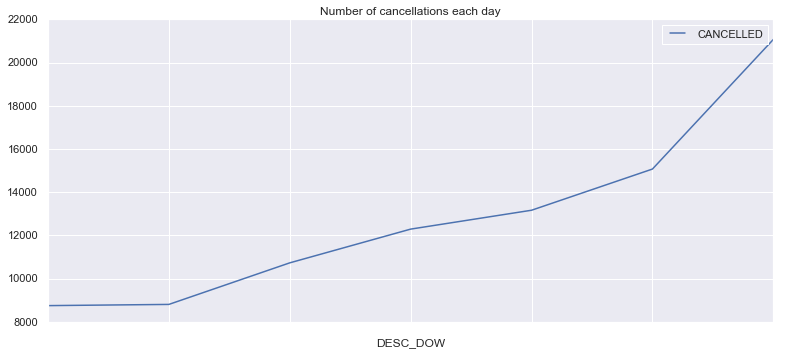

In [59]:
df_cancel.plot(kind='line', figsize=(13,6), subplots=True, legend=True)
plt.title('Number of cancellations each day')

In [60]:
df_reason = pd.DataFrame(flights.groupby(['DESC_AIRLINE'])['AIR_SYSTEM_DELAY', 'AIRLINE_DELAY',
                                                           'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY'].mean())
df_reason.head()

,AIR_SYSTEM_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY
DESC_AIRLINE,,,,
Alaska Airlines Inc.,13.487742,15.543352,17.064111,1.737294
American Airlines Inc.,13.513774,21.139201,21.747956,3.587838
American Eagle Airlines Inc.,15.372752,17.425025,23.404512,6.644508
Atlantic Southeast Airlines,15.459170,21.651277,24.078400,1.550713
Delta Air Lines Inc.,15.076578,22.941028,18.099252,5.108335


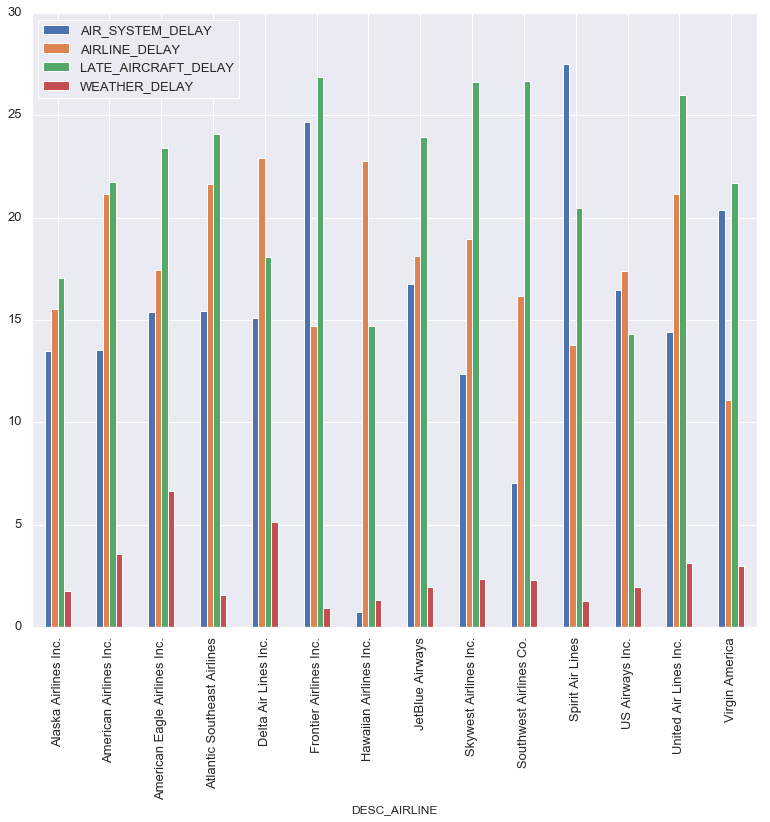

In [61]:
df_reason.plot.bar(legend = True,figsize = (13,11),rot=90)
plt.legend(loc=2,prop={'size':13})
plt.tick_params(labelsize = 13)

In [1]:
!jupyter nbconvert --to markdown Flight_Delay.ipynb
!mv Flight_Delay.md README.md

[NbConvertApp] Converting notebook Flight_Delay.ipynb to markdown
[NbConvertApp] Support files will be in Flight_Delay_files\
[NbConvertApp] Making directory Flight_Delay_files
[NbConvertApp] Making directory Flight_Delay_files
[NbConvertApp] Making directory Flight_Delay_files
[NbConvertApp] Making directory Flight_Delay_files
[NbConvertApp] Making directory Flight_Delay_files
[NbConvertApp] Making directory Flight_Delay_files
[NbConvertApp] Making directory Flight_Delay_files
[NbConvertApp] Making directory Flight_Delay_files
[NbConvertApp] Making directory Flight_Delay_files
[NbConvertApp] Making directory Flight_Delay_files
[NbConvertApp] Writing 32004 bytes to Flight_Delay.md
